## Use scale to pre-processing 11dim with time signals

## 1.Pre-processing use transform

In [1]:
import os
import time
import torch
import argparse
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from collections import defaultdict
import torch.multiprocessing as mp
import torch.utils.data
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import numpy

from models_11dim import VAE

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import torchvision.transforms as transforms
import torchvision.transforms.functional as F

device = torch.device('cuda:0')

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
# train_data = datasets.MNIST(root='data', train=True,
#                                    download=True, transform=transform)
# test_data = datasets.MNIST(root='data', train=False,
#                                   download=True, transform=transform)

# data_loader = DataLoader(
#     dataset=dataset, batch_size=args.batch_size, shuffle=True)
# print(len(train_data))

# dataset = MNIST(
#     root='data', train=True, transform=transforms.ToTensor(),
#     download=True)


sides_3 = np.load('../data/force_torque_sensor/Dataset/3_sides/Data/data.npy')
sides_4 = np.load('../data/force_torque_sensor/Dataset/4_sides/Data/data.npy')
sides_5 = np.load('../data/force_torque_sensor/Dataset/5_sides/Data/data.npy')
sides_6 = np.load('../data/force_torque_sensor/Dataset/6_sides/Data/data.npy')
sides_200 = np.load('../data/force_torque_sensor/Dataset/200_sides/Data/data.npy')



In [2]:
print(len(sides_3))
a = np.concatenate((sides_3,sides_4,sides_5,sides_6,sides_200),axis=0)
# b = np.append(a,sides_6)
# c= np.append(b,sides_200)
print(len(a))

sides_3=a

1585353
7926895


In [3]:
print(len(sides_3))


7926895


In [4]:
def feature_normalize(data):
    mu = np.mean(data,axis=0)
    std = np.std(data,axis=0)
    return (data - mu)/std

def un_normalize(normalized_data, input_data):
    mu = np.mean(input_data,axis=0)
    std = np.std(input_data,axis=0)
    return normalized_data*std+mu

In [5]:
def extract_trials(x, n):
#     x = feature_normalize(x)
    x = preprocessing.minmax_scale(x, feature_range=(0,1))
#     x = StandardScaler().fit(x)
    
    trials=[]
    trial=[]
    compare=0
    for sig in x:
        trial.append(sig[0:n])
        if sig[11] <= compare:
            d = 1002 - len(trial)
            if d >0:
                for i in range(d):
                    trial.append(np.zeros(len(sig[0:n])))
            trials.append(trial)
            trial=[]
        compare=sig[11]
    trials = np.array(trials)
    return trials       


In [6]:
dim=11 # without select the time and counter signal

sides_3_trials = extract_trials(sides_3, dim)
# sides_4_trials = extract_trials(sides_4, num)
# sides_5_trials = extract_trials(sides_5, num)
# sides_6_trials = extract_trials(sides_6, num)
# sides_200_trials = extract_trials(sides_200, num)




print(sides_3_trials[1580][999])

print(np.shape(sides_3_trials))
print(len(sides_3_trials[1000]))
print(sides_3_trials[1000])

[0.98641325 0.81037644 0.53989185 0.99889926 0.45734454 0.40110002
 0.95184929 0.51582105 0.4051353  0.59095241 0.99873658]
(7919, 1002, 11)
1002
[[0.98987766 0.3613637  0.64374661 ... 0.41791971 0.56796807 0.63171194]
 [0.98987766 0.3613637  0.64374661 ... 0.41710379 0.54039562 0.63171194]
 [0.98987766 0.3613637  0.64374661 ... 0.39969757 0.53538244 0.63171194]
 ...
 [0.98987766 0.3613637  0.64374661 ... 0.39697784 0.55543513 0.63171194]
 [0.98827149 0.45148331 0.56642947 ... 0.42791933 0.61388767 0.63234365]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [7]:
sides_3_trials = sides_3_trials[0:1580]
dataset = sides_3_trials

print(type(dataset))

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 10


# transform_dataset = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5,],std=[0.5])
# ])

# dataset = torch.from_numpy(dataset).double()
# # dataset = torch.FloatTensor(1, 1002, 11)
# # dataset = F.to_pil_image(dataset)
# dataset = transform_dataset(dataset)



data_loader = DataLoader(dataset=dataset, 
                         batch_size=batch_size, 
                         shuffle=True, 
                        )
train_loader = data_loader
valid_loader = data_loader
test_loader = data_loader

<class 'numpy.ndarray'>


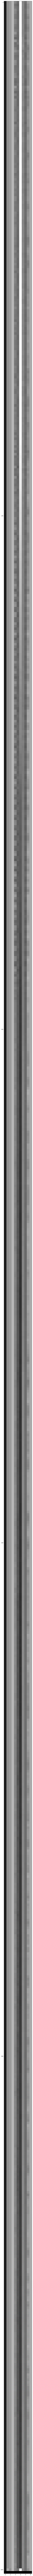

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(data_loader)
images = dataiter.next()
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,500)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

## Loss function

In [9]:
def loss_fn(recon_x, x, mean, log_var):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 1002*11), x.view(-1, 1002*11), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # elbo = recon_loss + self.beta * D_kl
    elbo = (BCE + KLD)/ x.size(0)
    return elbo

In [10]:
seed = 0
epochs = 50
latent_size = 2
num_processes = 2
learning_rate = 0.001
print_every = 100


vae = VAE(latent_size=latent_size).float().to(device)

# vae = VAE(
#     encoder_layer_sizes=encoder_layer_sizes,
#     latent_size=latent_size,
#     decoder_layer_sizes=decoder_layer_sizes).to(device)

use_cuda = torch.cuda.is_available
if use_cuda:
    vae.to(device)

logs = defaultdict(list)
    
epochs = epochs
for epoch in range(epochs):
    lr_havel = learning_rate
    optimizer = torch.optim.Adam(vae.parameters(), lr=lr_havel)
    
    for iteration, data in enumerate(train_loader):
        signals = data
        signals = signals.view(signals.size(0), -1)
        if use_cuda:
            signals = signals.to(device).float()
        else:
            signals = signals.float()

        optimizer.zero_grad()
        recon_x, mean, log_var, z = vae(signals)
        elbo = loss_fn(recon_x, signals, mean, log_var)
        loss = elbo
        loss.backward()
        optimizer.step()

        logs['loss'].append(loss.item())

        if iteration % print_every == 0 or iteration == len(train_loader)-1:
            valid_correct = 0
            valid_total = 0
            test_correct = 0
            test_total = 0

            for valid_data in valid_loader:
                valid = valid_data
                valid = signals.view(valid.size(0), -1)
                if use_cuda:
                    input_valid = valid.to(device).float()
                else:
                    input_valid = valid.float()
                valid_recon_x, valid_mean, valid_log_var, valid_z = vae(input_valid)
                valid_elbo = loss_fn(valid_recon_x, input_valid, valid_mean, valid_log_var)
                criterion = nn.MSELoss()
                valid_loss = criterion(valid_recon_x, input_valid)
                logs['valid_elbo'].append(valid_elbo.item())
                logs['valid_loss'].append(valid_loss.item())
                valid_total +=1
                if valid_loss < 0.05:
                    valid_correct += 1
            valid_acc = valid_correct / valid_total  
            print("Epoch {:02d}/{:02d} Batch {:04d}/{:d} |Train_ELBO {:5f} |Valid_ELBO{:5f} |Valid_loss{:5f} |Valid_accuary{:5f} |Leaarning_rate{:5f}".format(
                epoch, epochs, iteration, len(train_loader)-1, loss.item(), valid_elbo.item(), valid_loss.item(), valid_acc, lr_havel))

    lr_havel = lr_havel*0.9
    torch.save(vae, 'vae_all_signals_1002_scale_unscale_11dim_transform.pkl')  

Epoch 00/50 Batch 0000/157 |Train_ELBO 7936.689941 |Valid_ELBO7948.386230 |Valid_loss0.059630 |Valid_accuary0.000000 |Leaarning_rate0.001000
Epoch 00/50 Batch 0100/157 |Train_ELBO 7438.373535 |Valid_ELBO7395.824219 |Valid_loss0.033383 |Valid_accuary0.981013 |Leaarning_rate0.001000
Epoch 00/50 Batch 0157/157 |Train_ELBO 7285.734375 |Valid_ELBO7472.679199 |Valid_loss0.033059 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0000/157 |Train_ELBO 7724.886230 |Valid_ELBO7527.354004 |Valid_loss0.043033 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0100/157 |Train_ELBO 7471.632324 |Valid_ELBO7458.502441 |Valid_loss0.028235 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 01/50 Batch 0157/157 |Train_ELBO 7160.524414 |Valid_ELBO7115.057129 |Valid_loss0.017013 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 Batch 0000/157 |Train_ELBO 7140.754883 |Valid_ELBO7296.036133 |Valid_loss0.034614 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 02/50 B

Epoch 19/50 Batch 0157/157 |Train_ELBO 6874.093262 |Valid_ELBO6660.860840 |Valid_loss0.010290 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0000/157 |Train_ELBO 6945.800781 |Valid_ELBO6852.987793 |Valid_loss0.013524 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0100/157 |Train_ELBO 6731.305664 |Valid_ELBO6576.730469 |Valid_loss0.007658 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 20/50 Batch 0157/157 |Train_ELBO 6809.067383 |Valid_ELBO6770.372070 |Valid_loss0.011635 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0000/157 |Train_ELBO 7077.765137 |Valid_ELBO7053.287598 |Valid_loss0.020762 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0100/157 |Train_ELBO 7209.514160 |Valid_ELBO7212.329102 |Valid_loss0.017840 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 21/50 Batch 0157/157 |Train_ELBO 7099.436035 |Valid_ELBO7046.085449 |Valid_loss0.015636 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 22/50 B

Epoch 39/50 Batch 0100/157 |Train_ELBO 7060.599121 |Valid_ELBO7068.249512 |Valid_loss0.018440 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 39/50 Batch 0157/157 |Train_ELBO 6542.159668 |Valid_ELBO6594.145996 |Valid_loss0.009480 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0000/157 |Train_ELBO 7008.446777 |Valid_ELBO6977.748535 |Valid_loss0.008407 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0100/157 |Train_ELBO 6506.338867 |Valid_ELBO6523.263184 |Valid_loss0.013266 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 40/50 Batch 0157/157 |Train_ELBO 6882.270996 |Valid_ELBO6840.456543 |Valid_loss0.016302 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 Batch 0000/157 |Train_ELBO 6667.962402 |Valid_ELBO6591.618652 |Valid_loss0.007490 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 Batch 0100/157 |Train_ELBO 6954.574219 |Valid_ELBO6960.914062 |Valid_loss0.005994 |Valid_accuary1.000000 |Leaarning_rate0.001000
Epoch 41/50 B

# 2. Use the oringinal signal to Generate>>>>>>

In [11]:
vae = torch.load('vae_all_signals_1002_scale_unscale_11dim_transform.pkl').to(device)


In [12]:
import torch.utils.data

batch_size = 10
test_loader = data_loader

vae=vae.to(device)


recon_signals=[]
latent_space=[]

for iteration, test in enumerate(test_loader):
    test = test.view(test.size(0), -1)
    test = test.to(device).float()
    test_recon_x, test_mean, test_log_var, test_z = vae(test)
    test_recon_x = test_recon_x.view(batch_size, 1002, 11)
    test_recon_x=test_recon_x.cpu().detach().numpy()
    latent_space=test_z.cpu().detach().numpy()

    recon_signals.extend(test_recon_x)
#     latent_space.extend(latent_space)
    
#     if iteration ==10:
#         break
    
recon_signals = np.array(recon_signals)
latent_space = np.array(latent_space)

In [13]:
print(type(recon_signals[0]))
print(recon_signals[0])

print(len(recon_signals))
print(len(recon_signals[0]))
# print(recon_signals)

<class 'numpy.ndarray'>
[[0.27564925 0.69259703 0.5350607  ... 0.4096738  0.55161065 0.19983338]
 [0.2756591  0.69219756 0.5346568  ... 0.39971507 0.53755987 0.19914114]
 [0.2757127  0.6929064  0.53127927 ... 0.39275253 0.5230517  0.19944921]
 ...
 [0.2850671  0.6976845  0.52900004 ... 0.376596   0.5543013  0.1980113 ]
 [0.24951956 0.5273948  0.4558667  ... 0.35591072 0.47913054 0.16251488]
 [0.0147213  0.02637384 0.02422094 ... 0.01867573 0.02426645 0.00806567]]
1580
1002


In [14]:
# for i in range(len(recon_signals[0])):
#     recon_signals[:,i]=preprocessing.minmax_scale(
#         recon_signals[:,i], feature_range=(np.min(sides_3_trials[:,i]),np.max(sides_3_trials[:,i])))


# # recon_signals = un_normalize(recon_signals, sides_3_trials)
# generate_signals = recon_signals

# np.min(sides_3_trials[:,i])

## 2.1 Change shape

In [15]:
generate_signals=[]
for trial in recon_signals:
    generate_signals.extend(trial)
generate_signals = np.array(generate_signals)

print(np.shape(generate_signals))
print(len(generate_signals))

(1583160, 11)
1583160


## 2.1 Un pre-process(here we can select to train use normalize or scale and also generate)

In [16]:
for i in range(len(generate_signals[0])):
    generate_signals[:,i]=preprocessing.minmax_scale(
        generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
generated_signals=generate_signals

print(generated_signals[100])

[-3.4266771e-03  4.7896467e-03  1.2088739e-04 -5.4022603e-02
  6.7157536e+00  7.6496534e+00  8.2799149e-01  9.6618700e-01
  1.4368978e+00  6.6871628e-02  3.4088123e+02]


1583160


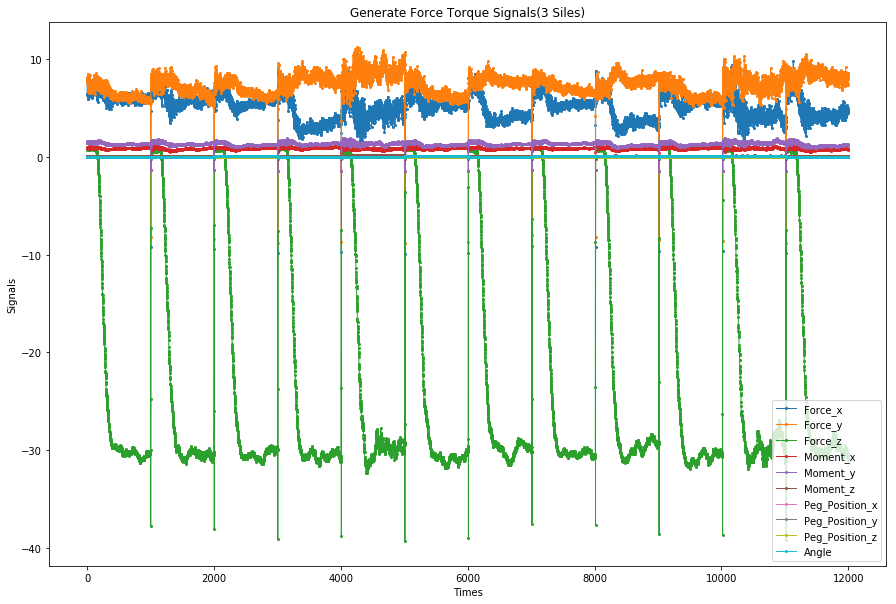

In [24]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = generated_signals
print(len(sides))

first = 0
slip = 12000

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][first:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][first:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][first:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][first:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][first:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][first:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][first:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][first:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][first:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][first:slip]
# Moment_z = sides[:,9][0:10:slip]


# # Time = sides[:,10]
# Time = sides[:,10][first:slip]
# # Time = sides[:,10][0:10:slip]

# # Counter = sides[:,11]
# Counter = sides[:,11][first:slip]
# # Counter = sides[:,11][0:10:slip]

# # print(Counter[1001])
# print(min(Counter))
# print(max(Counter))


# x = Time
x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Generate Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
# plt.savefig("peg_position_and_angle_mini_generate.png")
plt.show()


# 3. Use the random latent space to Generate>>>>>>


[[ 0.09863605  6.461601  ]
 [ 1.1737169   1.0596752 ]
 [-0.6530687  -0.25284868]
 [-0.544651   -0.9122468 ]
 [ 0.13729621  0.5709202 ]
 [ 0.45697853  0.5297639 ]
 [ 1.5122079  -4.4120536 ]
 [-4.076979    2.668741  ]
 [ 2.2685502  -1.0473744 ]
 [-3.040659   -2.3734744 ]]


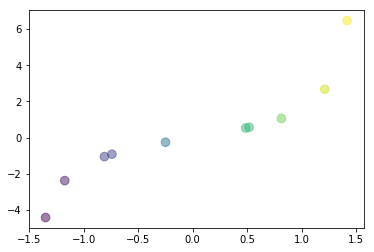

In [18]:
print(latent_space)

import matplotlib.pyplot as plt
import numpy as np
X = latent_space[:,0]
Y = latent_space[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)

tensor([[ 1.7805, -0.3885],
        [-1.4705, -0.6592],
        [ 0.8509,  1.1040],
        [-1.2006,  0.1583],
        [-2.0689, -0.8055],
        [ 0.5930, -0.0604],
        [ 0.4744,  0.8755],
        [ 0.9012,  1.9530],
        [ 0.7617,  0.2316],
        [ 0.2756,  0.4213]], device='cuda:0')


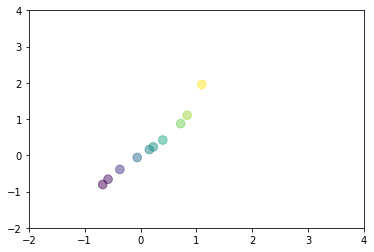

In [19]:
# batch_size = 10
z = torch.randn([batch_size, 2]).to(device)
# z = torch.FloatTensor(latent_space).to(device)


visual_z = z.cpu().numpy()
import matplotlib.pyplot as plt
import numpy as np
X = visual_z[:,0]
Y = visual_z[:,1]

colors = np.arctan(Y,X) # color

plt.scatter(X, Y, s=75, c=colors, alpha=.5)
plt.xlim(-2,4)
plt.ylim(-2,4)

print(z)

In [20]:
recon_x = vae.decoder(z)

print(type(recon_x[0]))
print(recon_x[0])

print(len(recon_x))
print(len(recon_x[0]))

print(recon_x[0])

<class 'torch.Tensor'>
tensor([0.8549, 0.6708, 0.4887,  ..., 0.0042, 0.0051, 0.0024], device='cuda:0',
       grad_fn=<SelectBackward>)
10
11022
tensor([0.8549, 0.6708, 0.4887,  ..., 0.0042, 0.0051, 0.0024], device='cuda:0',
       grad_fn=<SelectBackward>)


In [21]:
recon_x = recon_x.view(batch_size,1002,11)
# generate_signals = recon_x.cpu().detach().numpy()

z_generate_signals=[]
for trial in recon_x:
    trial = trial.cpu().detach().numpy()
    z_generate_signals.extend(trial)
z_generate_signals = np.array(z_generate_signals)


# print(np.shape(generate_signals))
print(len(z_generate_signals))
# print(generate_signals[0])
# print(type(generate_signals))


10020


In [22]:
for i in range(len(z_generate_signals[0])):
    z_generate_signals[:,i]=preprocessing.minmax_scale(
        z_generate_signals[:,i], feature_range=(np.min(sides_3[:,i]),np.max(sides_3[:,i])))
    
z_generated_signals=z_generate_signals

print(len(z_generated_signals))
print(np.shape(z_generated_signals))

10020
(10020, 11)


10020


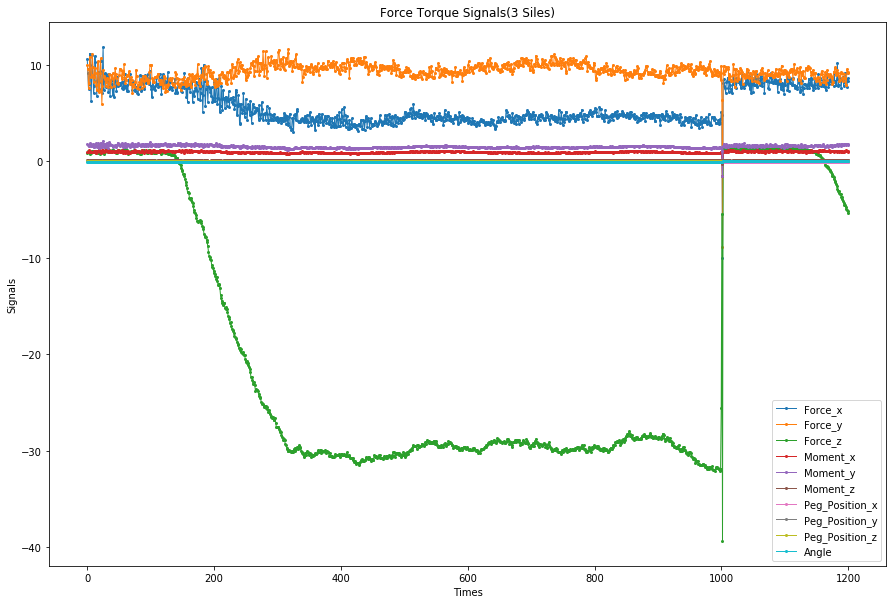

In [23]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

cmap=plt.cm.get_cmap(plt.cm.viridis,143)


# plt.rcParams['font.size'] = 11.
# plt.rcParams['font.family'] = 'Comic Sans MS'
# plt.rcParams['axes.labelsize'] = 15.
# plt.rcParams['xtick.labelsize'] = 10.
# plt.rcParams['ytick.labelsize'] = 10.

plt.figure(figsize=(15,10))



sides = z_generate_signals
print(len(sides))

slip = 1200

# Peg_Position_x = sides[:,0]
Peg_Position_x = sides[:,0][:slip]
# Peg_Position_x = sides[:,0][0:10:slip]

# Peg_Position_y = sides[:,1]
Peg_Position_y = sides[:,1][:slip]
# Peg_Position_y = sides[:,1][0:10:slip]

# Peg_Position_z = sides[:,2]
Peg_Position_z = sides[:,2][:slip]
# Peg_Position_z = sides[:,2][0:10:slip]

# Angle = sides[:,3]
Angle = sides[:,3][:slip]
# Angle = sides[:,3][0:10:slip]

# Force_x = sides[:,4]
Force_x = sides[:,4][:slip]
# Force_x = sides[:,4][0:10:slip]

# Force_y = sides[:,5]
Force_y = sides[:,5][:slip]
# Force_y = sides[:,5][0:10:slip]

# Force_z = sides[:,6]
Force_z = sides[:,6][:slip]
# Force_z = sides[:,6][0:10:slip]

# Moment_x = sides[:,7]
Moment_x = sides[:,7][:slip]
# Moment_x = sides[:,7][0:10:slip]

# Moment_y = sides[:,8]
Moment_y = sides[:,8][:slip]
# Moment_y = sides[:,8][0:10:slip]

# Moment_z = sides[:,9]
Moment_z = sides[:,9][:slip]
# Moment_z = sides[:,9][0:10:slip]

x = np.linspace(0,len(Moment_z),len(Moment_z))

plt.plot(x, Force_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_x')
plt.plot(x, Force_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_y')
plt.plot(x, Force_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Force_z')

plt.plot(x, Moment_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_x')
plt.plot(x, Moment_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_y')
plt.plot(x, Moment_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Moment_z')

plt.plot(x, Peg_Position_x, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_x')
plt.plot(x, Peg_Position_y, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_y')
plt.plot(x, Peg_Position_z, marker='o', linestyle='-', markersize=2, linewidth=1, label='Peg_Position_z')

plt.plot(x, Angle, marker='o', linestyle='-', markersize=2, linewidth=1, label='Angle')
# plt.plot(x, Counter, marker='o', linestyle='-', markersize=2, linewidth=1, label='Counter')


plt.xlabel('Times')
plt.ylabel('Signals')
plt.title('Force Torque Signals(3 Siles)')
plt.legend(loc='lower right')
plt.show()